import some Prerequisites

In [1]:
from sklearn.datasets import load_breast_cancer
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib import pyplot as plt
import random
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


seprate 20% of data for test 20% for valdiation and 60% for training

In [2]:
data = load_breast_cancer()
m = len(data.target)

test_size = m//5
val_size = m//5

X_val = data.data[:val_size]
X_test = data.data[val_size:val_size+test_size]
X_train = data.data[val_size+test_size:]

y_val = data.target[:val_size]
y_test = data.target[val_size:val_size+test_size]
y_train = data.target[val_size+test_size:]

n = len(data.data[0])

print(' features num = {} \n validation size = {} \n test size = {} \n train size = {}'.format(n,val_size,test_size,m-val_size-test_size))

 features num = 30 
 validation size = 113 
 test size = 113 
 train size = 343


define a EarlyStopping callback 

In [0]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5)

create a mlp model

In [0]:
def create_model(optimizer = 'adam',activation = 'relu',nn = 10 , nl = 1):
  model = Sequential()
  for i in range(nl):
    model.add(Dense(nn,input_shape=(n,),activation = activation))
  
  model.add(Dense(1,activation = 'sigmoid'))
  model.compile(optimizer = optimizer ,loss='binary_crossentropy',metrics=['accuracy'])
  return model


find the best hyperparameters for model using scikit with 3 fold cross validation

In [5]:
model = KerasClassifier(build_fn = create_model,epochs = 30 )
params = dict(optimizer = ['sgd','adam'] ,activation = ['relu','tanh'],nn = [5,10,20],batch_size = [4,32,128],nl=[1,2])
random_search = RandomizedSearchCV(model,param_distributions=params,verbose=1,cv = 3,n_jobs=-1) #using all processors.
random_search.fit(X_train,y_train,verbose = 0)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f12281bc0b8>,
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'batch_size': [4, 32, 128],
                                        'nl': [1, 2], 'nn': [5, 10, 20],
                                        'optimizer': ['sgd', 'adam']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=1)

In [19]:
print('best score = {} using {}'.format(random_search.best_score_,random_search.best_params_))
best_optimizer = random_search.best_params_['optimizer']
best_activation = random_search.best_params_['activation']
best_nn = random_search.best_params_['nn']
best_nl = random_search.best_params_['nl']
best_batch_size =random_search.best_batch_size = random_search.best_params_['batch_size']

best score = 0.9241291681925455 using {'optimizer': 'adam', 'nn': 5, 'nl': 1, 'batch_size': 4, 'activation': 'relu'}


train the model with best hyperparameters we've found

In [7]:
model = create_model(best_optimizer,best_activation,best_nn,best_nl)
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_val,y_val),callbacks=[early_stopping],batch_size = best_batch_size)


Train on 343 samples, validate on 113 samples
Epoch 1/30
343/343 [==============================] - 0s 544us/step - loss: 18.6497 - accuracy: 0.1866 - val_loss: 15.5415 - val_accuracy: 0.1858
Epoch 2/30
343/343 [==============================] - 0s 353us/step - loss: 12.2466 - accuracy: 0.1808 - val_loss: 10.8195 - val_accuracy: 0.2301
Epoch 3/30
343/343 [==============================] - 0s 314us/step - loss: 7.0925 - accuracy: 0.3440 - val_loss: 3.9512 - val_accuracy: 0.4690
Epoch 4/30
343/343 [==============================] - 0s 317us/step - loss: 3.9245 - accuracy: 0.4781 - val_loss: 1.8743 - val_accuracy: 0.5487
Epoch 5/30
343/343 [==============================] - 0s 350us/step - loss: 1.8110 - accuracy: 0.6822 - val_loss: 1.6371 - val_accuracy: 0.6549
Epoch 6/30
343/343 [==============================] - 0s 347us/step - loss: 1.1591 - accuracy: 0.7755 - val_loss: 0.8047 - val_accuracy: 0.7699
Epoch 7/30
343/343 [==============================] - 0s 315us/step - loss: 0.7742 - a

test the model

In [8]:
result = model.evaluate(X_test,y_test)
print('accuracy ={} loss={}'.format(result[1],result[0]))

113/113 [==============================] - 0s 43us/step
accuracy =0.8230088353157043 loss=0.9326828370052102


plot the results

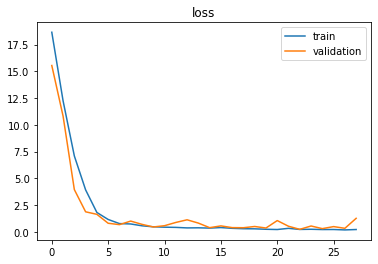

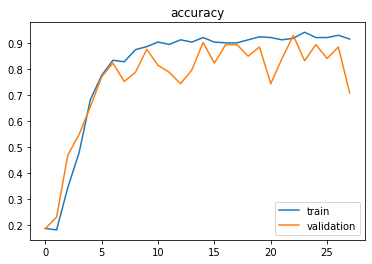

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend(['train' ,'validation'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['train' ,'validation'])
plt.show()

save the model

In [0]:
save_model(model,'saved_model.hdf5')

load the model

In [0]:
model = load_model('saved_model.hdf5')

predict some tumor results :)

In [18]:
t = random.randint(0,m)
print('data = {} \n\n actual result = {} \n predicted result = {} '.
      format( data.data[t] 
             ,data.target_names[data.target[t]] 
             ,data.target_names[model.predict_classes(np.array([data.data[t]]))[0][0]] ))

data = [1.754e+01 1.932e+01 1.151e+02 9.516e+02 8.968e-02 1.198e-01 1.036e-01
 7.488e-02 1.506e-01 5.491e-02 3.971e-01 8.282e-01 3.088e+00 4.073e+01
 6.090e-03 2.569e-02 2.713e-02 1.345e-02 1.594e-02 2.658e-03 2.042e+01
 2.584e+01 1.395e+02 1.239e+03 1.381e-01 3.420e-01 3.508e-01 1.939e-01
 2.928e-01 7.867e-02] 

 actual result = malignant 
 predicted result = malignant 
